In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

##Methods Overview:
  1) Time Series Regression 
      - Additive decomposition: estimate trend, seasonal, cyclical, and irregular factors
      
  

#Time Series Regression

##First: Exploratory menual aggregation of the Data

In [2]:
#first daata..
df = pd.read_csv('data/birth.txt', delim_whitespace=True)

In [3]:
#create some dates that go with the birth. Its a Time! 
df['dates'] = pd.date_range('1980-01','2011-01', freq='M') #AS for anual, 
df.head()

,num_births,dates
0,295,1980-01-31
1,286,1980-02-29
2,300,1980-03-31
3,278,1980-04-30
4,272,1980-05-31


In [4]:
#example 2. The first six days in january, 2013:
dates = pd.date_range('20130101', periods = 6)
print dates

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06'],
              dtype='datetime64[ns]', freq='D', tz=None)


###make the dates an index!

In [5]:
d_dateindex = df.set_index('dates')
d_dateindex.head()

,num_births
dates,
1980-01-31,295
1980-02-29,286
1980-03-31,300
1980-04-30,278
1980-05-31,272


##Get the month or Day as a New column!

In [6]:
df['months'] = pd.DatetimeIndex(df['dates']).month
df['years'] = pd.DatetimeIndex(df['dates']).year
df.head()

,num_births,dates,months,years
0,295,1980-01-31,1,1980
1,286,1980-02-29,2,1980
2,300,1980-03-31,3,1980
3,278,1980-04-30,4,1980
4,272,1980-05-31,5,1980


###Resample Quarterly:

follows the season, with Nov starting as fall

In [7]:
#need datetime as index

d_dateindex.resample('Q-Nov').head()

,num_births
dates,
1980-02-29,290.500000
1980-05-31,283.333333
1980-08-31,299.000000
1980-11-30,304.000000
1981-02-28,287.666667


##Use Groupby to Get Cool Aggregates by Month/year! 

if you have the dates as and index, you can use pd.TimeGrouper

In [8]:
year_averages = d_dateindex.groupby(pd.TimeGrouper(freq='AS')).agg(np.mean)
year_averages.head()

,num_births
dates,
1980-01-01,294.666667
1981-01-01,296.166667
1982-01-01,296.166667
1983-01-01,312.583333
1984-01-01,320.416667


or, make the year a seperate column, and just use groupby....

In [9]:
df.groupby(['years'])['num_births'].mean()

years
1980    294.666667
1981    296.166667
1982    296.166667
1983    312.583333
1984    320.416667
1985    325.000000
1986    335.000000
1987    337.166667
1988    347.000000
1989    354.416667
1990    350.333333
1991    353.750000
1992    353.916667
1993    356.750000
1994    347.083333
1995    341.750000
1996    337.750000
1997    313.833333
1998    302.500000
1999    293.916667
2000    290.416667
2001    297.750000
2002    309.916667
2003    296.666667
2004    271.333333
2005    261.500000
2006    263.833333
2007    262.416667
2008    265.583333
2009    275.000000
2010    278.666667
Name: num_births, dtype: float64

In [10]:
df.groupby(['months'])['num_births'].mean()

months
1     306.225806
2     288.451613
3     308.935484
4     290.580645
5     300.483871
6     304.129032
7     327.870968
8     334.161290
9     330.032258
10    322.838710
11    305.645161
12    313.516129
Name: num_births, dtype: float64

###Cool Example to Plot cyclical Data

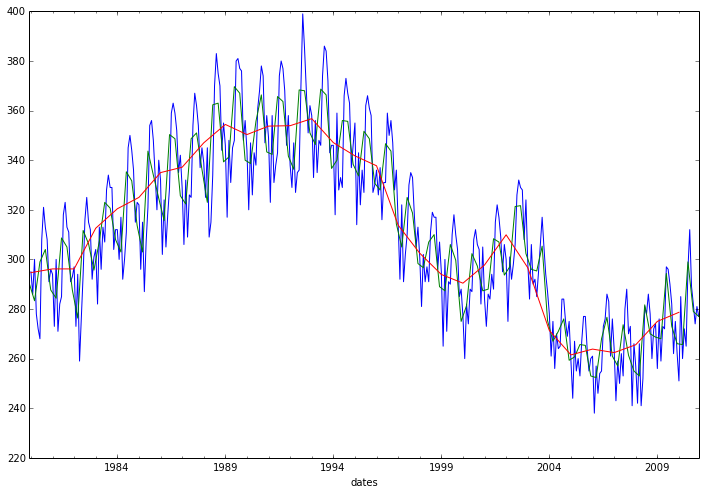

In [11]:
#turn it into a timeseries by taking it out of a dataframe
ts = pd.Series(d_dateindex['num_births'])

ts.plot(figsize=(12,8)) #this is the daily data (blue)
ts.resample('Q-NOV').plot() #seasons (red)
ts.resample('A').plot() #yearly (green)

plt.show()

##CREATE A MODEL: Time Series Regression

####create a time variable for modeling:

In [12]:
d_dateindex['time'] = range(1,d_dateindex.shape[0]+1)
d_dateindex.head()

,num_births,time
dates,,
1980-01-31,295,1
1980-02-29,286,2
1980-03-31,300,3
1980-04-30,278,4
1980-05-31,272,5


####create multivariate xs for modeling:

In [13]:
d_dateindex['time^2'] = d_dateindex['time']**2
d_dateindex['time^3'] = d_dateindex['time']**3 
d_dateindex['time^4'] = d_dateindex['time']**4 
d_dateindex['time^5'] = d_dateindex['time']**5 
d_dateindex.head()

,num_births,time,time^2,time^3,time^4,time^5
dates,,,,,,
1980-01-31,295,1,1,1,1,1
1980-02-29,286,2,4,8,16,32
1980-03-31,300,3,9,27,81,243
1980-04-30,278,4,16,64,256,1024
1980-05-31,272,5,25,125,625,3125


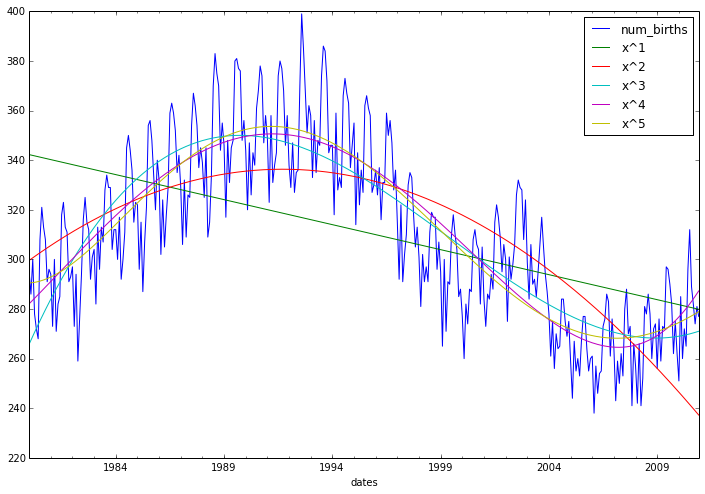

In [14]:
y = d_dateindex.num_births

def make_model(y, x_values):
    ts.plot(figsize=(12,8))
    for i,x in enumerate(x_values):
        xs = x_values[:i+1]
        x_value = d_dateindex[xs]
        model = sm.OLS(y, sm.add_constant(x_value)).fit()
        
        labname = 'x^' + str(i+1) 
        pd.Series(model.fittedvalues, index = d_dateindex.index).plot(label=labname)

make_model(y, ['time', 'time^2', 'time^3', 'time^4', 'time^5'])
plt.legend()
plt.show()

In [15]:
def evaluate_model(y,Xs):
    for i, x in enumerate(Xs):        
        xs = d_dateindex[Xs[:i+1]]
        print
        model = sm.OLS(y, sm.add_constant(xs)).fit()
        print model.summary()
        
evaluate_model(y, ['time', 'time^2', 'time^3', 'time^4', 'time^5'])
'''
X | AIC | BIC
-------------
1  3593  3601
2  3400  3412
3  3262  3278
4  3231  3251
5  3224  3243
'''


                            OLS Regression Results                            
Dep. Variable:             num_births   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     133.0
Date:                Sun, 19 Jul 2015   Prob (F-statistic):           1.72e-26
Time:                        14:32:37   Log-Likelihood:                -1794.5
No. Observations:                 372   AIC:                             3593.
Df Residuals:                     370   BIC:                             3601.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        342.4232      3.137    109.148      0.

'\nX | AIC | BIC\n-------------\n1  3593  3601\n2  3400  3412\n3  3262  3278\n4  3231  3251\n5  3224  3243\n'

###oops.. break it down! The loops make it confusing!

So, an exaple to add two constants:
    

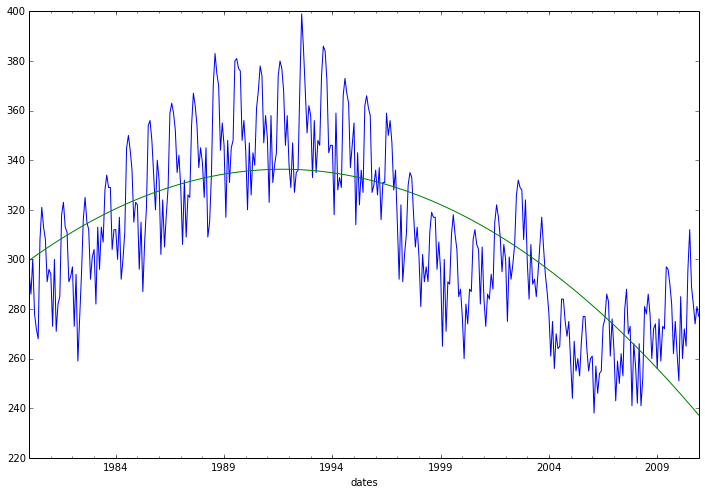

In [16]:
y = d_dateindex['num_births']
X = d_dateindex[['time', 'time^2']]
model = sm.OLS(y, sm.add_constant(X)).fit()
ts.plot(figsize=(12,8))
pd.Series(model.fittedvalues, index=d_dateindex.index).plot()

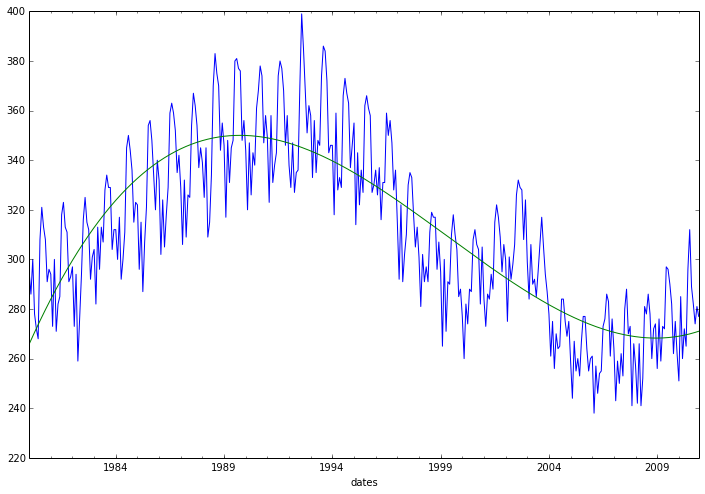

In [25]:
X = d_dateindex[['time', 'time^2', 'time^3']]
model = sm.OLS(y, sm.add_constant(X)).fit()
ts.plot(figsize=(12,8))
pd.Series(model.fittedvalues, index=d_dateindex.index).plot()

###Account for Categorical Variables: Such as Months Canging
We can account for more variables than just adding terms to X (time)
We might want to incorporate the fact that all the months change.
- to do this, make months a dummy variable, so that you include waht month it is in the model. This is added to the other x's (time, time^2, ect)

In [18]:
d_dateindex['month'] = pd.DatetimeIndex(d_dateindex.index).month
X = pd.get_dummies(d_dateindex[['time', 'time^2', 'time^3', 'time^4','month']], columns=['month']).drop(['month_1'], axis = 1)

In [19]:
d_dateindex.head()

,num_births,time,time^2,time^3,time^4,time^5,month
dates,,,,,,,
1980-01-31,295,1,1,1,1,1,1
1980-02-29,286,2,4,8,16,32,2
1980-03-31,300,3,9,27,81,243,3
1980-04-30,278,4,16,64,256,1024,4
1980-05-31,272,5,25,125,625,3125,5


In [22]:
X.head()

,time,time^2,time^3,time^4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
dates,,,,,,,,,,,,,,,
1980-01-31,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1980-02-29,2,4,8,16,1,0,0,0,0,0,0,0,0,0,0
1980-03-31,3,9,27,81,0,1,0,0,0,0,0,0,0,0,0
1980-04-30,4,16,64,256,0,0,1,0,0,0,0,0,0,0,0
1980-05-31,5,25,125,625,0,0,0,1,0,0,0,0,0,0,0


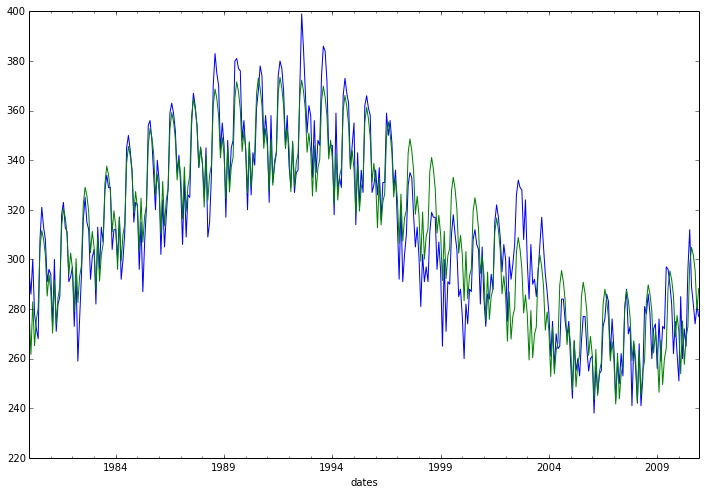

In [23]:
model = sm.OLS(y, sm.add_constant(X)).fit()
ts.plot(figsize=(12,8))
pd.Series(model.fittedvalues, index=d_dateindex.index).plot()



##Plot Residuals
Goal: We want the residulas to show no correlation of the model

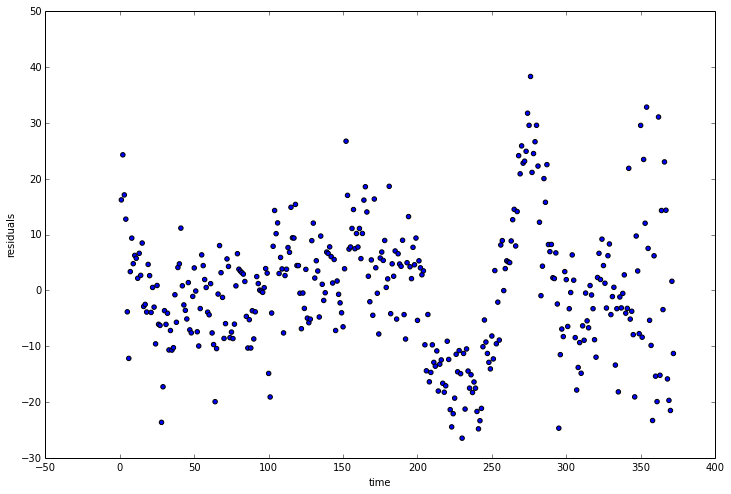

In [21]:
d_dateindex['residuals'] = model.resid
d_dateindex.plot(x = 'time', y = 'residuals', kind = 'scatter', figsize=(12,8))

#2) ARIMA

##1. Format Data 
First, load the data (the dataset for this exercise is located in data/logins.json)

Lets turn the series into a pandas TimeSeries

We would like to resample the data to a daily frequency (and to an hourly frequency for use later)

In [29]:
ts = pd.read_json('data/logins.json', typ='series')
ts = pd.Series(1, index = ts)
ts.head()

2012-03-01 00:05:55    1
2012-03-01 00:06:23    1
2012-03-01 00:06:52    1
2012-03-01 00:11:23    1
2012-03-01 00:12:47    1
dtype: int64

get counts by hour

or day

In [31]:
dailyts =ts.resample('D', how = 'count')
dailyts.head()

2012-03-01    268
2012-03-02    314
2012-03-03    521
2012-03-04    499
2012-03-05    202
Freq: D, dtype: int64

In [30]:
hourlyts =ts.resample('H', how = 'count')
hourlyts.head()

2012-03-01 00:00:00    31
2012-03-01 01:00:00    18
2012-03-01 02:00:00    37
2012-03-01 03:00:00    23
2012-03-01 04:00:00    14
Freq: H, dtype: int64

see the stuff!

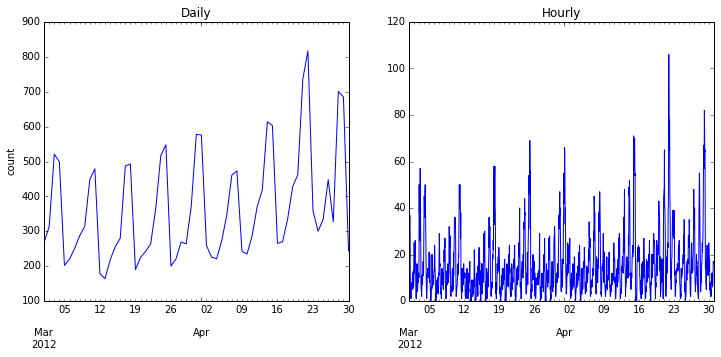

In [33]:
plt.subplot(1,2,1, ylabel = 'count')
dailyts.plot(figsize = (12,5), title = 'Daily')
plt.subplot(1,2,2)
hourlyts.plot(title = 'Hourly')
plt.show()

Create a dataframe that has count and dayofweek features

In [34]:
thedf = pd.DataFrame(dailyts).rename(columns={0:'count'})
thedf['dayofweek'] = thedf.index.dayofweek
thedf['weekend'] = (thedf['dayofweek'] > 4).astype(int)
thedf.head()

,count,dayofweek,weekend
2012-03-01,268,3,0
2012-03-02,314,4,0
2012-03-03,521,5,1
2012-03-04,499,6,1
2012-03-05,202,0,0


##2. Plot the ACF and PACF
###A. Make sure the data is stationary: Look at the ACF. Lags should die fast. Is not, need to address it.

In [35]:
def acf_pacf(ts, lags):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(ts, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(ts, lags=lags, ax=ax2)

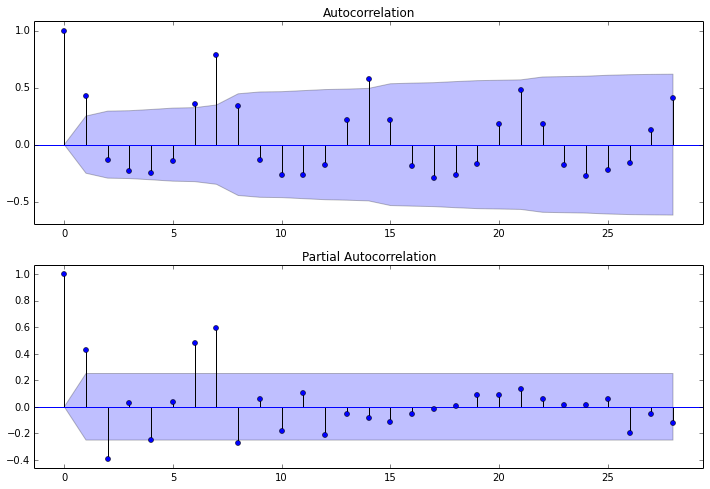

In [37]:
acf_pacf(dailyts, 28)

These show the data is NOT stationary: The mean and variance are CHANGING over time
The solution to this is to DETREND the data. Use OLS (ordinary least squares regression). The residuals will be the new time series.
##3. Detrend the Data (resolve stationarity). Two methods.
###I. Plot the Residuals

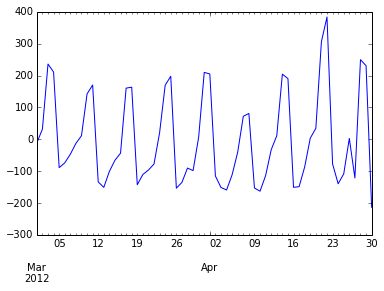

In [51]:
X = range(1, dailyts.shape[0]+1)
y= dailyts.values #the count

model = sm.OLS(y, sm.add_constant(X)).fit()
newy = model.resid

#plugged the y (residuals) back into a series, 
#so I could have the time as the y axis
detrend_ts = pd.Series(newy, index =dailyts.index )
detrend_ts.plot()
plt.show()


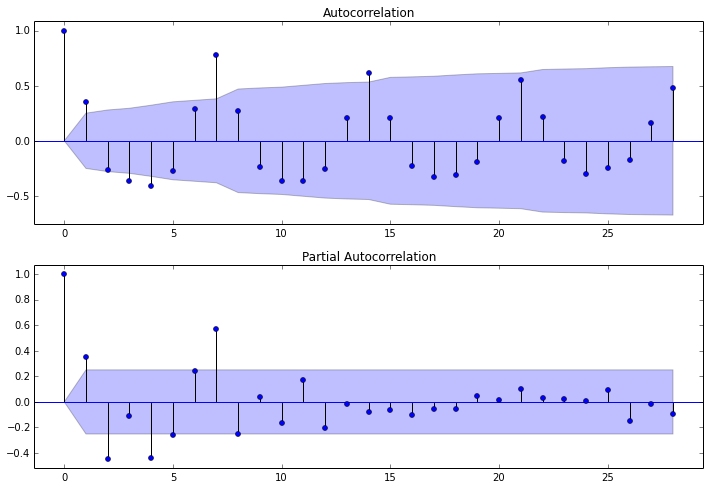

In [52]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(detrend_ts, lags=28, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(detrend_ts, lags=28, ax=ax2)

###II. Differing Function
Another way to achieve stationarity in the data is to use the differencing function (1st difference can remove linear trend; 2nd order difference can remove curvature, etc).
In some cases with seasonal data, the seasonal difference has to be taken to achieve stationarity, i.e. the difference between this January and the last January if the data is monthly.

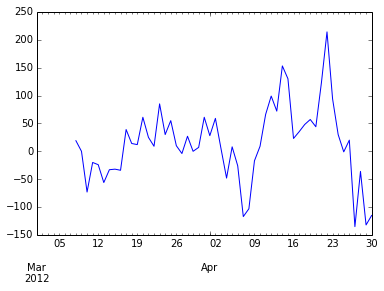

In [53]:
ts_difference7 = dailyts.diff(periods=7)


detrend_ts = pd.Series(ts_difference7, index =dailyts.index )
detrend_ts.plot()
plt.show()


#see? this is good! It looks stationaary! 

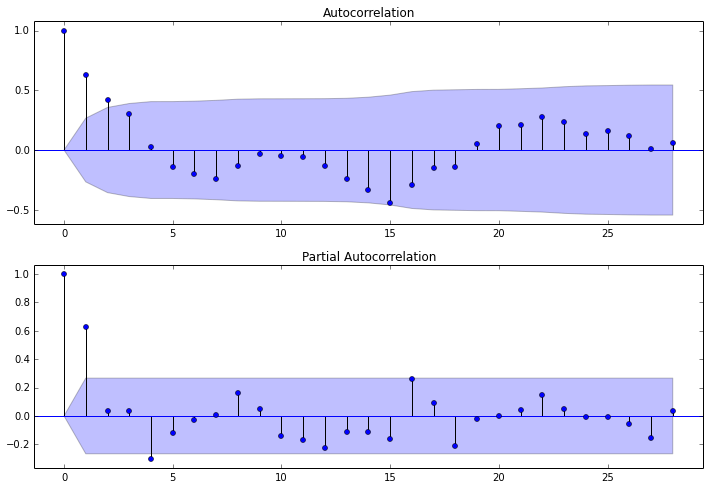

In [42]:
fig = plt.figure(figsize=(12,8))

#28 lags because that is about 4 weeks
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_difference7[7:], lags=28, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_difference7[7:], lags=28, ax=ax2)

##4. Fit a series of seasonal ARIMA models of order (p,d,q)x(P,D,Q)xL to the original day data.

In [43]:
model=sm.tsa.SARIMAX(dailyts, order=(0,1,1), seasonal_order=(0,1,0,7)).fit()
model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   61
Model:             SARIMAX(0, 1, 1)x(0, 1, 0, 7)   Log Likelihood                -286.699
Date:                           Sun, 19 Jul 2015   AIC                            577.398
Time:                                   15:31:11   BIC                            581.620
Sample:                               03-01-2012   HQIC                           579.053
                                    - 04-30-2012                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ma.L1         -0.2768      0.136     -2.037      0.042        -0.543    -0.010
sigma2      2919.9546    556.887      5.243      0.000      1828.477  4011.432
==============================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients.
"""

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pd.Series(model.resid().flatten(),index=dailyts.index), lags=28, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pd.Series(model.resid().flatten(),index=dailyts.index), lags=28, ax=ax2)